In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


In [2]:
# data loading

path_temp_trks = '/training/tracking-nuclear/test.trks'
all_data = [load_trks(path_temp_trks)]

In [3]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [01:19<00:00,  6.63s/it]
2022-07-07 16:43:16.160873: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-07 16:43:16.768163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10396 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


CPU times: user 9min 6s, sys: 11min 7s, total: 20min 13s
Wall time: 2min 33s


In [4]:
%%time
track_info = concat_tracks(all_tracks)

CPU times: user 462 ms, sys: 647 ms, total: 1.11 s
Wall time: 1.11 s


In [5]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

In [6]:
for k, v in track_info.items():
    print(k, v.shape)

appearances (12, 71, 331, 32, 32, 1)
centroids (12, 71, 331, 2)
morphologies (12, 71, 331, 3)
adj_matrices (12, 71, 331, 331)
norm_adj_matrices (12, 71, 331, 331)
temporal_adj_matrices (12, 70, 331, 331, 3)


In [7]:
type(track_info['appearances'])

numpy.ndarray

In [8]:
app = track_info['appearances']
batches = app.shape[0]
frames = app.shape[1]
cells = app.shape[2]

real_img_nums_dict = dict.fromkeys(range(batches))
for batch in range(batches):
    real_img_nums_dict[batch] = {}
print(real_img_nums_dict)

# Gets number of real cells in each batch
for batch in range(batches):
    for cell in range(cells):
        if np.max(app[batch, 0, cell]) != 0:
            last_frame = 71
            for frame in range(frames):
                if np.max(app[batch, frame, cell]) == 0:
                    last_frame = frame
                    break
            real_img_nums_dict[batch][cell] = last_frame
        else:
            break
print(real_img_nums_dict)

num_real_imgs = sum([sum([num_frames for num_frames in real_img_nums_dict[batch].values()]) for batch in real_img_nums_dict.keys()])
print("Non-blank images: " + str(num_real_imgs))

{0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}
{0: {0: 49, 1: 50, 2: 17, 3: 50, 4: 38}, 1: {0: 50, 1: 50, 2: 48, 3: 50, 4: 50, 5: 1, 6: 50, 7: 50, 8: 7}, 2: {0: 65, 1: 53, 2: 65, 3: 27, 4: 54, 5: 65, 6: 65, 7: 43, 8: 39, 9: 65, 10: 3, 11: 32, 12: 55, 13: 36, 14: 47, 15: 31, 16: 65, 17: 17, 18: 65, 19: 65, 20: 37, 21: 25, 22: 18, 23: 65, 24: 38, 25: 44, 26: 65, 27: 65, 28: 33, 29: 29, 30: 65, 31: 65, 32: 65, 33: 65, 34: 30, 35: 56, 36: 65, 37: 32, 38: 58, 39: 65, 40: 65, 41: 39, 42: 65, 43: 65, 44: 51, 45: 65, 46: 33, 47: 54, 48: 65, 49: 65, 50: 65, 51: 65, 52: 29, 53: 65, 54: 65, 55: 65, 56: 65, 57: 65, 58: 65, 59: 65, 60: 65, 61: 65, 62: 52, 63: 65, 64: 48, 65: 65, 66: 65, 67: 24, 68: 65, 69: 65, 70: 19, 71: 55, 72: 65, 73: 30, 74: 65, 75: 35, 76: 65, 77: 65, 78: 29, 79: 26, 80: 65, 81: 65, 82: 65, 83: 65, 84: 65, 85: 27, 86: 65, 87: 1, 88: 37, 89: 65, 90: 52, 91: 65, 92: 65, 93: 10, 94: 51, 95: 18, 96: 37, 97: 1, 98: 65, 99: 65, 100: 19, 101: 6

In [9]:
real_img_list = []
for batch in range(batches):
    for cell in real_img_nums_dict[batch].keys():
        for frame in range(real_img_nums_dict[batch][cell]):
            real_img_list.append(app[batch][frame][cell])
appearances = np.array(real_img_list)

In [10]:
# Gets index of non-blank image (from original array) in (pruned) array of non-blank images
def get_real_idx(batch, frame, cell):
    assert (cell in real_img_nums_dict[batch].keys() and frame < real_img_nums_dict[batch][cell]), "Blank image"
    idx = 0
    for b in range(batch):
        idx += sum(real_img_nums_dict[b].values())
    for c in range(cell):
        idx += real_img_nums_dict[batch][c]
    idx += frame
    return idx

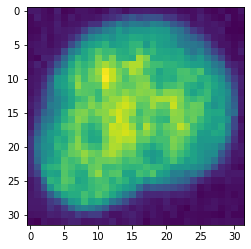

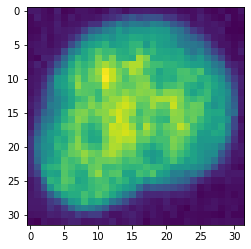

In [11]:
import matplotlib.pyplot as plt

batch = 10
frame = 10
cell = 10

fig, ax = plt.subplots()
ax.imshow(track_info['appearances'][batch][frame][cell])

fig, ax = plt.subplots()
ax.imshow(appearances[get_real_idx(batch, frame, cell)])

In [12]:
app_shape = np.shape(appearances)

# Appearances not being normalized yet (will have to slightly modify norm function
# since we don't have this organized by life cycle

input_dict = {'appearances': appearances}

output_dict = {'appearances_decoder': appearances}

data = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))

data = data.repeat().batch(1)

In [13]:
it = iter(data)

In [14]:
nxt = it.next()
type(nxt)

tuple

In [15]:
print(len(nxt))
print(nxt[0].keys())
print(nxt[1].keys())

2
dict_keys(['appearances'])
dict_keys(['appearances_decoder'])


In [16]:
print(type(nxt[0]['appearances']))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [17]:
print(nxt[0]['appearances'].get_shape())

(1, 32, 32, 1)


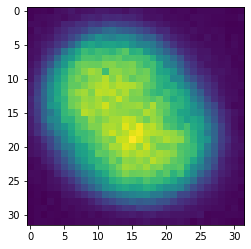

In [18]:
fig, ax = plt.subplots()
ax.imshow(nxt[0]['appearances'][0].numpy().astype('float32'))